In [1]:
import os
import pandas as pd
import seaborn as sns
from sciviso import Scatterplot
from scircm import SciRCM
from scivae import Vis
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '../data/S050_CCRCC_Clark_Cell2019/'
fig_dir = '../figures/sircle/all_patients/all_cpgs/'
output_dir = f'{base_dir}sircle/all_patients/'
data_dir = f'{base_dir}sircle/all_patients/'
supp_dir =  f'{base_dir}supps/'
test_title = 'all_patients_ccRCC'
meth_test_title = 'all_patients_ccRCC'


## Filter DNA methylation genes

Here we want to assign 1 CpG to each gene (i.e. we want to identify the "driver" CpG).  

We determine this by first finding CpGs that are in agreement in terms of direction of regulation.  

1) Group CpGs that fall within 1000 bp of the TSS  
2) If there are at least 3 CpGs then check that at least 60% of CpGs argree in terms of direction of change (and have a pvalue < 0.1)  
3) If they do then retain the CpG with the largest DNA methylation difference (in the direction that 60% agreed on)  
4) If there were less than 3 CpGs just keep the CpG with the largest DNA methylation difference. 
`

--------------------------------------------------------------------------------
      Originally had: 	25434	genes.
	Filtered DF now has: 	21377	 genes.	       
--------------------------------------------------------------------------------


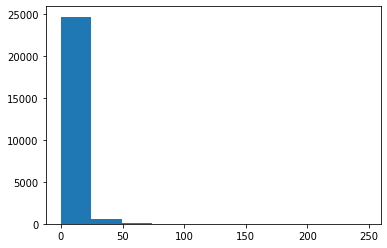

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 21377.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
        1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 <BarContainer object of 20 artists>)

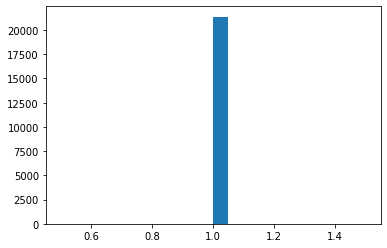

In [2]:
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

u = SciUtil()
df = pd.read_csv(f'{data_dir}cpg_DE_{meth_test_title}_sircle.csv')
# t value = t, adj.P.Val = adjusted P, cpg_id = CpG id, logFC=logfold change
# Only include those with a adj p value < 0.1
run_meth_filter = True

def filter_by_genes(cpg_df):
    cpg_df_grped = cpg_df.groupby('ensembl_gene_id')
    p_val = 'padj_meth'
    logfc = 'CpG_Beta_diff'
    rows = []
    num_cpgs = []
    for cpg in cpg_df_grped:
        cpg = cpg[1]
        cpg = cpg[cpg[p_val] < 0.05]
        num_cpgs.append(len(cpg))
        if len(cpg) > 0:
            if len(cpg) < 3:
                add_row = True
            else:
                pos_cpg = cpg[cpg[logfc] > 0]
                neg_cpg = cpg[cpg[logfc] < 0]
                num_pos = len(pos_cpg)
                num_neg = len(neg_cpg)
                add_row = False
                if num_pos and num_pos/len(cpg) > 0.6:
                    cpg = pos_cpg
                    add_row = True
                elif num_neg and num_neg/len(cpg) > 0.6:
                    cpg = neg_cpg
                    add_row = True
            if add_row:
                max_cpg_idx = None
                max_t_value = 0 # absolute
                idxs = cpg.index
                for i, t in enumerate(cpg[logfc].values):
                    if abs(t) > abs(max_t_value):
                        max_t_value = t
                        max_cpg_idx = i
                rows.append(cpg[cpg.index == idxs[max_cpg_idx]].values[0])
    new_cpg_df = pd.DataFrame(rows, columns=cpg_df.columns)
    u.dp(['Originally had: ', len(cpg_df_grped), 'genes.\n', 'Filtered DF now has: ', len(new_cpg_df), ' genes.'])
    plt.hist(num_cpgs)
    plt.show()
    return new_cpg_df

# Replace inf
# replace logFC col neg and +ve inf
df['logFC_meth'].replace([np.inf],max(df['logFC_meth'].replace(np.inf, np.nan)),inplace=True)
df['logFC_meth'].replace([-np.inf],min(df['logFC_meth'].replace(-np.inf, np.nan)),inplace=True)
normal_cols = [c for c in df.columns if 'Normal' in c]
tumor_cols = [c for c in df.columns if 'Tumor' in c]
beta_diff = np.mean(df[tumor_cols].values, axis=1) - np.mean(df[normal_cols].values, axis=1)
df['CpG_Beta_diff'] = beta_diff

df = filter_by_genes(df)

gene_counts = df['ensembl_gene_id'].value_counts()
plt.hist(gene_counts.values, bins=20) # Gives an idea of the number of CpGs per gene

In [142]:
df.to_csv(f'{data_dir}filtered_cpg_DE_{meth_test_title}_sircle.csv', index=False)


(array([2.100e+01, 3.350e+02, 2.853e+03, 1.267e+04, 3.529e+03, 1.723e+03,
        2.220e+02, 1.900e+01, 4.000e+00, 1.000e+00]),
 array([-6.12807518, -4.66566197, -3.20324877, -1.74083557, -0.27842237,
         1.18399083,  2.64640403,  4.10881723,  5.57123043,  7.03364363,
         8.49605683]),
 <BarContainer object of 10 artists>)

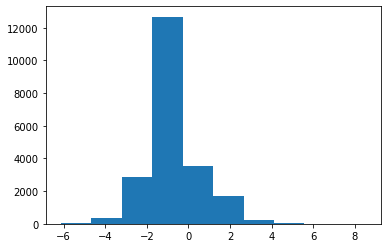

In [3]:
plt.hist(df['logFC_meth'])

In [4]:
mean_change = np.mean(df[[c for c in df.columns if 'Tumor' in c]].values, axis=1) - np.mean(df[[c for c in df.columns if 'Normal' in c]].values, axis=1)


(array([3.0000e+00, 1.5000e+01, 2.2700e+02, 2.4680e+03, 1.1099e+04,
        5.5180e+03, 1.8960e+03, 1.4300e+02, 7.0000e+00, 1.0000e+00]),
 array([-0.9412186 , -0.76283261, -0.58444662, -0.40606062, -0.22767463,
        -0.04928864,  0.12909735,  0.30748334,  0.48586933,  0.66425533,
         0.84264132]),
 <BarContainer object of 10 artists>)

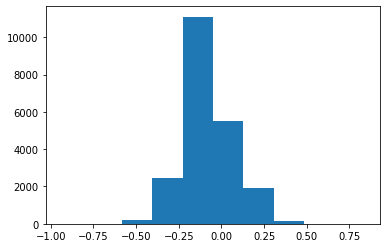

In [5]:
plt.hist(mean_change)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 21377.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

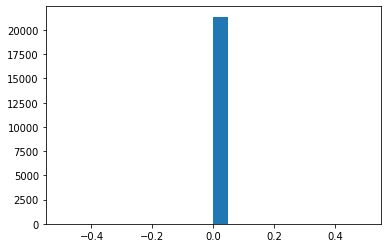

In [6]:
plt.hist(np.log2(gene_counts.values), bins=20)

In [8]:
meth_df = pd.read_csv(f'{data_dir}cpg_DE_{meth_test_title}_sircle.csv')
meth_f_df = pd.read_csv(f'{data_dir}filtered_cpg_DE_{meth_test_title}_sircle.csv')
gene_counts = meth_df['ensembl_gene_id'].value_counts()
print(len(gene_counts[gene_counts < 3]), len(gene_counts[gene_counts > 3]), len(gene_counts[gene_counts > 20])) #6713 15848 1400

6713 15848 1400


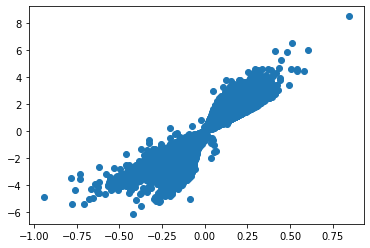

In [9]:
plt.scatter(meth_f_df["CpG_Beta_diff"].values, meth_f_df["logFC_meth"].values)

In [41]:
meth_df[meth_df['external_gene_name'] == 'CA9']

,Unnamed: 0,Locus,chr,pos,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,Relation_to_Island,UCSC_RefGene_Group,...,CpG_Normal_d781be9c.7b3b.4acf.b202.d4d4b847db05_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_c92995d5.68ce.47d0.8149.0323e624c032_1,CpG_Normal_f29b6c8c.d713.42ad.9b90.e556df9b05cd_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ac092a8e.80af.4589.8bb8.d86427b398ca_1,CpG_Normal_318f6ffb.1fdf.4f74.90db.21e337503aae_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
53104,cg06908460,cg06908460,chr9,35676107,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.071525,0.073432,0.056048,0.061662,0.057470,0.061828,0.089296,0.060925,0.075332,0.013317
71975,cg09566069,cg09566069,chr9,35676368,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.188227,0.189941,0.207914,0.189651,0.196477,0.184108,0.335658,0.183858,0.252410,0.056579
100054,cg13849253,cg13849253,chr9,35676169,ENSG00000107159,CA9,CA9,768,Island,Body,...,0.041222,0.067208,0.049146,0.054657,0.035332,0.081421,0.117577,0.047883,0.069222,0.002398
105670,cg14563831,cg14563831,chr9,35679278,ENSG00000107159,CA9,CA9,768,S_Shelf,Body,...,0.890417,0.940949,0.922212,0.921867,0.934773,0.919804,0.938456,0.893177,0.923882,-0.021328
135379,cg19257550,cg19257550,chr9,35673912,ENSG00000107159,CA9,CA9,768,N_Shore,TSS200,...,0.545057,0.590555,0.494968,0.602210,0.731530,0.526126,0.595478,0.549169,0.736935,-0.038873
143713,cg20610181,cg20610181,chr9,35674003,ENSG00000107159,CA9,CA9,768,N_Shore,1stExon,...,0.812362,0.863635,0.851431,0.850729,0.945040,0.831214,0.802052,0.889678,0.895687,-0.363275


TSS1500    5796
5'UTR      5784
3'UTR      4862
TSS200     2573
1stExon    2130
ExonBnd     232
Name: GencodeCompV12_Group_FILT, dtype: int64
--------------------------------------------------------------------------------
                                   V	E	G	F	A	                                   
--------------------------------------------------------------------------------


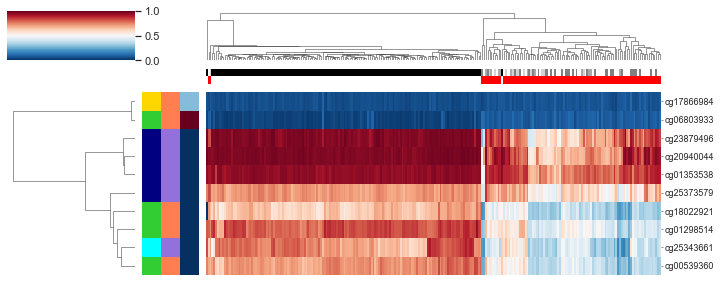

3244    cg01298514
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                   C	X	C	R	4	                                   
--------------------------------------------------------------------------------


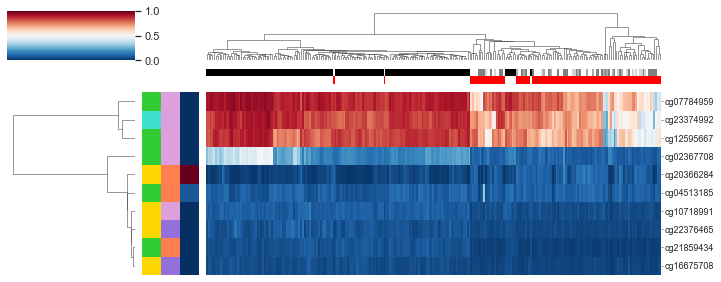

4112    cg23374992
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                   H	M	O	X	1	                                   
--------------------------------------------------------------------------------


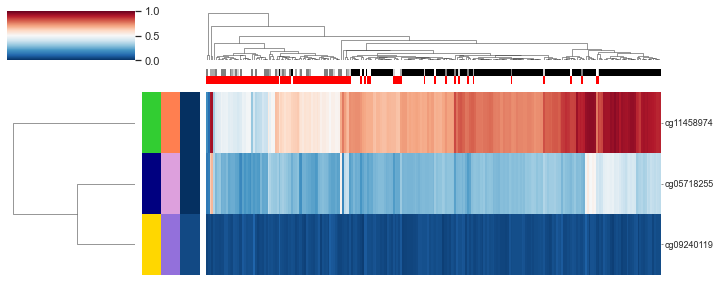

1796    cg11458974
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                   G	A	P	D	H	                                   
--------------------------------------------------------------------------------


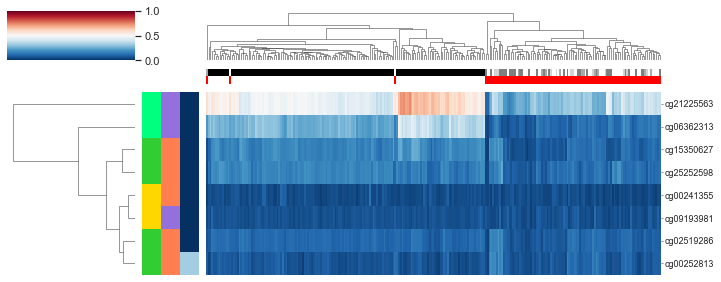

3101    cg21225563
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                     H	K	2	                                     
--------------------------------------------------------------------------------


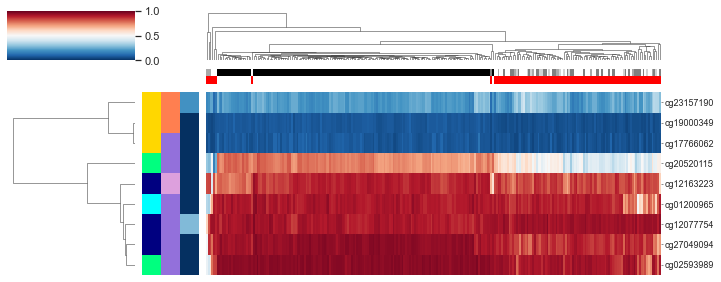

8146    cg20520115
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                     M	E	T	                                     
--------------------------------------------------------------------------------


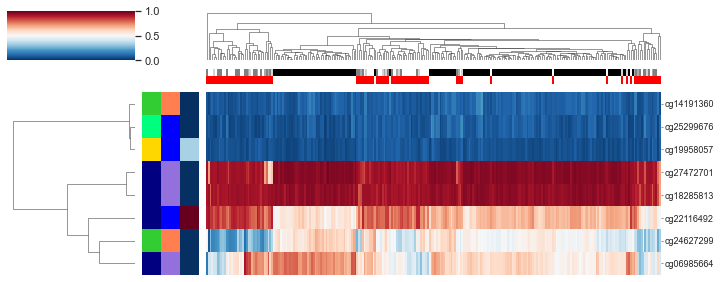

2565    cg24627299
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

--------------------------------------------------------------------------------
                                    L	D	H	A	                                    
--------------------------------------------------------------------------------


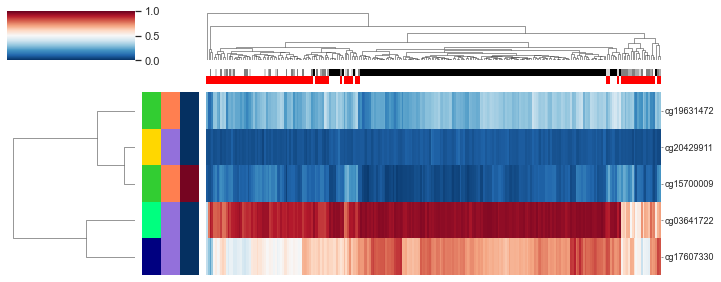

5428    cg17607330
Name: Locus, dtype: object


<Figure size 720x288 with 0 Axes>

In [12]:

from sciviso import Heatmap
clin_df = pd.read_csv(f'{data_dir}../meth_sample_df_sircle_ccRCC.csv', index_col=0)
clin_df = clin_df[clin_df['CondName'] == 'Tumor']
stage_1_cases = clin_df[clin_df['TumorStage'] == 'Stage I']['FullLabel'].values
stage_2_cases = clin_df[clin_df['TumorStage'] == 'Stage II']['FullLabel'].values
stage_3_cases = clin_df[clin_df['TumorStage'] == 'Stage III']['FullLabel'].values
stage_4_cases = clin_df[clin_df['TumorStage'] == 'Stage IV']['FullLabel'].values

genes = ['VEGFA', 'CXCR4', 'HMOX1', 'GAPDH', 'HK2', 'MET', 'LDHA'] #['MAP4K3', 'MACROH2A2', 'EMX1', 'TFAP2A', 'ACOX2', 'HOXD4'] #['VEGFA', "EGFF", 'CCND1', 'HLA', 'IGFBP3', 'HMOX1']
gene_label = "TPDS"

df_genes = meth_df.groupby(['external_gene_name'])
filtered_df_genes = meth_f_df.groupby(['external_gene_name'])
print(meth_f_df['GencodeCompV12_Group_FILT'].value_counts())

def plot_hm(x_df):
    gene_df = x_df.get_group(gene)
    gene_df = gene_df.sort_values(by=['logFC_meth'])
    labels = gene_df['Relation_to_Island'].values
    lut = {'OpenSea': "navy",
     'Island': "gold",
           "N_Shore": "limegreen",
           "S_Shore": "springgreen",
     'N_Shelf': "turquoise",
     'S_Shelf': "aqua"}
    row_colors = pd.DataFrame(labels)[0].map(lut)

    # Create additional row_colors here
    labels = gene_df['GencodeCompV12_Group_FILT'].values
    lut = {'ExonBnd': "purple",
     "3'UTR": "plum",
     "5'UTR": "mediumpurple",
      "TSS200": "darkorange",
     'TSS1500': "coral", "1stExon": "blue", "0": "white"}
    row_colors2 = pd.DataFrame(labels)[0].map(lut).values

    logfc =  gene_df['logFC_meth'].values
    rdBu = plt.get_cmap('RdBu_r')
    logfc = rdBu(logfc)
    tumor_cols = [c for c in df.columns if 'Tumor' in c or 'Normal' in c]
    colours = []
    for c in tumor_cols:
        if c in stage_1_cases:
            colours.append("white")
        elif c in stage_2_cases:
            colours.append("lightgrey")
        elif c in stage_3_cases:
            colours.append("grey")
        elif c in stage_4_cases:
            colours.append("darkgrey")
        else:
            colours.append("black")

    type_colours = []
    for c in tumor_cols:
        if 'Normal' in c:
            type_colours.append("white")
        else:
            type_colours.append("red")

    opts = {'axis_font_size': 9, "axis_font_weight": 400, "title_font_size": 16, "title_font_weight": 400, "text_font_weight": 400}
    if len(gene_df) > 1:
        heatmap = Heatmap(gene_df, tumor_cols, 'Locus',
                          row_colours=[row_colors, row_colors2, logfc], col_colours=[colours, type_colours],
                          figsize=(10, 4),  vmin=0, vmax=1, cluster_rows=True,
                          linewidths=0, x_tick_labels=0, config=opts)
        heatmap.plot()
    else:
        print(gene_df['Locus'])
        # heatmap = Heatmap(gene_df, tumor_cols, 'Locus',
        #               row_colours=[row_colors, row_colors2, logfc], col_colours=[colours, type_colours],
        #               figsize=(10, 1),  vmin=0, vmax=1, cluster_rows=False, cluster_cols=True,
        #               linewidths=0, x_tick_labels=0, config=opts)
        # heatmap.plot()
    plt.savefig(f'{fig_dir}heatmap_all_patients_ccRCC_{gene_label}_{gene}.svg')
    plt.show()


for gene in genes:
    u.dp(gene)
    plot_hm(df_genes)
    plot_hm(filtered_df_genes)



In [157]:
mmp14 = meth_df[meth_df['external_gene_name'] == 'MMP14']
mmp14

,Unnamed: 0,Locus,chr,pos,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,Relation_to_Island,UCSC_RefGene_Group,...,CpG_Normal_d781be9c.7b3b.4acf.b202.d4d4b847db05_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_c92995d5.68ce.47d0.8149.0323e624c032_1,CpG_Normal_f29b6c8c.d713.42ad.9b90.e556df9b05cd_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ac092a8e.80af.4589.8bb8.d86427b398ca_1,CpG_Normal_318f6ffb.1fdf.4f74.90db.21e337503aae_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
12345,cg01508380,cg01508380,chr14,22836376,ENSG00000157227,MMP14,MMP14,4323,N_Shore,TSS1500,...,0.044091,0.053861,0.060915,0.045951,0.047012,0.086882,0.212343,0.058893,0.074947,0.105826
18811,cg02316283,cg02316283,chr14,22844657,ENSG00000157227,MMP14,MMP14,4323,N_Shore,Body,...,0.939594,0.923240,0.883299,0.915678,0.942116,0.918121,0.872941,0.938540,0.914955,-0.057383
33392,cg04219048,cg04219048,chr14,22845819,ENSG00000157227,MMP14,MMP14,4323,Island,Body,...,0.878838,0.924680,0.882228,0.884085,0.908429,0.907878,0.883705,0.910054,0.906390,-0.016544
46057,cg05931439,cg05931439,chr14,22836748,ENSG00000157227,MMP14,MMP14,4323,Island,5'UTR;1stExon,...,0.019062,0.023170,0.034419,0.023866,0.014600,0.039042,0.143945,0.017762,0.019308,0.088199
63458,cg08321366,cg08321366,chr14,22836626,ENSG00000157227,MMP14,MMP14,4323,N_Shore,5'UTR;1stExon,...,0.049424,0.059021,0.056539,0.049757,0.042620,0.091823,0.191377,0.044027,0.061829,0.095156
77717,cg10418289,cg10418289,chr14,22839085,ENSG00000157227,MMP14,MMP14,4323,S_Shore,Body,...,0.516699,0.532214,0.492251,0.528055,0.667738,0.505538,0.386700,0.634543,0.618258,-0.133443
78990,cg10599444,cg10599444,chr14,22836732,ENSG00000157227,MMP14,MMP14,4323,Island,5'UTR;1stExon,...,0.058683,0.047473,0.092482,0.040102,0.039947,0.076367,0.221002,0.051850,0.039050,0.138643
94634,cg13094752,cg13094752,chr14,22836339,ENSG00000157227,MMP14,MMP14,4323,N_Shore,TSS1500,...,0.090065,0.110743,0.137108,0.099701,0.095829,0.134480,0.299370,0.114333,0.135785,0.113620
115575,cg16119835,cg16119835,chr14,22837641,ENSG00000157227,MMP14,MMP14,4323,Island,Body,...,0.053223,0.034161,0.053454,0.033660,0.041782,0.062638,0.132099,0.056601,0.048476,0.051811
129041,cg18207699,cg18207699,chr14,22847130,ENSG00000157227,MMP14,MMP14,4323,S_Shore,3'UTR,...,0.837351,0.859715,0.826467,0.835705,0.871369,0.823359,0.838974,0.822073,0.866591,-0.033738


In [13]:
meth_df['logFC_meth'].replace([np.inf],max(meth_df['logFC_meth'].replace(np.inf, np.nan)),inplace=True)
meth_df['logFC_meth'].replace([-np.inf],min(meth_df['logFC_meth'].replace(-np.inf, np.nan)),inplace=True)
normal_cols = [c for c in meth_df.columns if 'Normal' in c]
tumor_cols = [c for c in meth_df.columns if 'Tumor' in c]
beta_diff = np.mean(meth_df[tumor_cols].values, axis=1) - np.mean(meth_df[normal_cols].values, axis=1)
meth_df['CpG_Beta_diff'] = beta_diff


# Save as a bed file so we can easily see which one we chose using IGV

In [14]:
# Save the locus, chr, pos, and gene name to a CSV (along with cpgBetaDiff) to use for the peak files
meth_to_save = meth_df[['Locus', 'chr', 'pos', 'external_gene_name', 'CpG_Beta_diff', 'padj_meth']]
meth_to_save['Sig'] = ['*' if c < 0.05 else '' for c in meth_df['padj_meth'].values]


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_13157/2313789727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_to_save['Sig'] = ['*' if c < 0.05 else '' for c in meth_df['padj_meth'].values]


In [15]:
loci = {}
for l in meth_f_df['Locus'].values:
    loci[l] = True
    chosen=[]
for l in meth_to_save['Locus'].values:
    if loci.get(l):
        chosen.append('+')
    else:
        chosen.append(" ")
meth_to_save['Chosen'] = chosen


meth_to_save['Name'] = meth_to_save['Chosen'] + meth_to_save['Locus'] + '(' + meth_to_save['Sig'] + meth_to_save['external_gene_name'] + ')'

meth_to_save.to_csv(f'{data_dir}cpg_DE_{meth_test_title}_sircle_locus_info.csv')
meth_f_df[['Locus', 'chr', 'pos', 'external_gene_name', 'CpG_Beta_diff', 'padj_meth']].to_csv(f'{data_dir}cpg_filtered_DE_{meth_test_title}_sircle_locus_info.csv')


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_13157/817225396.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_to_save['Chosen'] = chosen
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_13157/817225396.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meth_to_save['Name'] = meth_to_save['Chosen'] + meth_to_save['Locus'] + '(' + meth_to_save['Sig'] + meth_to_save['external_gene_name'] + ')'


In [38]:
from scie2g.csv import Csv, Epi2GeneException

# We read in the file and then convert it to a BED file so that we can load it in IGV
filepath = f'{data_dir}cpg_DE_{meth_test_title}_sircle_locus_info.csv'
df = pd.read_csv(filepath)
f = Csv(filepath,  'chr', 'pos', 'pos', 'CpG_Beta_diff', ['Locus', 'external_gene_name'], sep=',')
f.convert_to_bed(df, f'files/cpg_DE_all_patients_ccRCC_sircle_locus.bed',
                 'CPTAC TCGA CpG', None, 'Name')


## Plot the CpGs: supplementary figure

Here we want to plot the CpGs and how they map to genes, also report the total number of "up" and "down" CpGs.


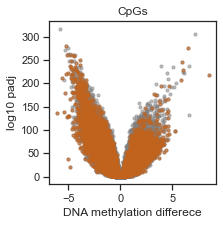

--------------------------------------------------------------------------------
       Original number of CpGs: 	187770	 Filtered number of CpGs: 	21377	       
--------------------------------------------------------------------------------


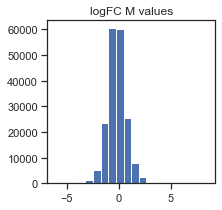

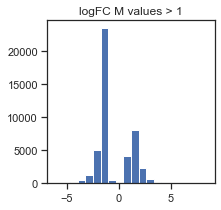

In [17]:
"""
---------------------------------------------------------------
            Plot and identify the largest direction of change for the CpGs
---------------------------------------------------------------
"""

plt.rcParams["figure.figsize"] = (3,3)

# Plot a scatter in grey of the original dataset
plt.scatter(meth_df['logFC_meth'].values, -1 * np.log10(meth_df['padj_meth'].values), c='grey', alpha=0.5, s=10)
# plot a scatter in colour for the filtered dataset 
plt.scatter(meth_f_df['logFC_meth'].values, -1 * np.log10(meth_f_df['padj_meth'].values), c='#C2631D', s=10,
            alpha=0.5)
plt.title('CpGs')
plt.xlabel('DNA methylation differece')
plt.ylabel('log10 padj')
plt.savefig(f'{fig_dir}SFig1_CpGs_{meth_test_title}.svg')
plt.show()

# Print the respective sizes of the datasets
u.dp(['Original number of CpGs: ', len(meth_df), ' Filtered number of CpGs: ', len(meth_f_df)])

plt.hist(meth_df['logFC_meth'].values, bins=20)
plt.title('logFC M values')
plt.show()

plt.hist(meth_df['logFC_meth'].values[np.where(abs(meth_df['logFC_meth'].values) > 1.0)], bins=20)
plt.title('logFC M values > 1')
plt.show()


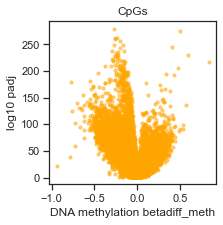

--------------------------------------------------------------------------------
       Original number of CpGs: 	187770	 Filtered number of CpGs: 	21377	       
--------------------------------------------------------------------------------


In [18]:
"""
---------------------------------------------------------------
            Plot and identify the largest direction of change for the CpGs
---------------------------------------------------------------
"""
plt.rcParams["figure.figsize"] = (3,3)

# Save the meth DF to csv
#meth_f_df.to_csv(meth_filtered_file, index=False)
plt.scatter(meth_f_df['CpG_Beta_diff'].values, -1 * np.log10(meth_f_df['padj_meth'].values), c='orange', alpha=0.5, s=10)

# plot a scatter in colour for the filtered dataset 
plt.title('CpGs')
plt.xlabel('DNA methylation betadiff_meth')
plt.ylabel('log10 padj')
plt.savefig(f'{fig_dir}SFig1_CpGs_beta_{meth_test_title}.svg')
plt.show()

# Print the respective sizes of the datasets
u.dp(['Original number of CpGs: ', len(meth_df), ' Filtered number of CpGs: ', len(meth_f_df)])



In [19]:
m_cutoff = 1.0
# Print out the number of hypo and hyper methylated genes
u.dp(['Original Hyper-methylated:',  len(meth_df[meth_df['logFC_meth'].values > m_cutoff]), 
      'Original Hypo-methylated:',len(meth_df[meth_df['logFC_meth'].values < -m_cutoff])])

u.warn_p(['Filtered Hyper-methylated:',  len(meth_f_df[meth_f_df['logFC_meth'].values > m_cutoff]), 
          'Filtered Hypo-methylated:', len(meth_f_df[meth_f_df['logFC_meth'].values < -m_cutoff])])
        
u.dp(['Percentage All Hyper-methylated:', 100*(len(meth_df[meth_df['logFC_meth'].values > m_cutoff])/len(meth_df)), 
     'Percentage All Hypo-methylated:', 100*(len(meth_df[meth_df['logFC_meth'].values < -m_cutoff])/len(meth_df))])
      
u.warn_p(['Percentage Filtered Hyper-methylated:', 100*(len(meth_f_df[meth_f_df['logFC_meth'].values > m_cutoff])/len(meth_f_df)), 
     'Percentage Filtered Hypo-methylated:', 100*(len(meth_f_df[meth_f_df['logFC_meth'].values < -m_cutoff])/len(meth_f_df))])
      

--------------------------------------------------------------------------------
       Original Hyper-methylated:	15306	Original Hypo-methylated:	31140	        
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
        Filtered Hyper-methylated:	2474	Filtered Hypo-methylated:	9450	         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage All Hyper-methylated:	8.151461894871385	Percentage All Hypo-methylated:	16.584118868828888	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage Filtered Hyper-methylated:	11.573186134630678	Percentage Filtered Hypo-methylated:	44.20639004537587	
-------------------------------------------------------

In [20]:
m_cutoff = 0.5
# Print out the number of hypo and hyper methylated genes
u.dp(['Original Hyper-methylated:',  len(meth_df[meth_df['CpG_Beta_diff'].values > m_cutoff]), 
      'Original Hypo-methylated:',len(meth_df[meth_df['CpG_Beta_diff'].values < -m_cutoff])])

u.warn_p(['Filtered Hyper-methylated:',  len(meth_f_df[meth_f_df['CpG_Beta_diff'].values > m_cutoff]), 
          'Filtered Hypo-methylated:', len(meth_f_df[meth_f_df['CpG_Beta_diff'].values < -m_cutoff])])
        
u.dp(['Percentage All Hyper-methylated:', 100*(len(meth_df[meth_df['CpG_Beta_diff'].values > m_cutoff])/len(meth_df)), 
     'Percentage All Hypo-methylated:', 100*(len(meth_df[meth_df['CpG_Beta_diff'].values < -m_cutoff])/len(meth_df))])
      
u.warn_p(['Percentage Filtered Hyper-methylated:', 100*(len(meth_f_df[meth_f_df['CpG_Beta_diff'].values > m_cutoff])/len(meth_f_df)), 
     'Percentage Filtered Hypo-methylated:', 100*(len(meth_f_df[meth_f_df['CpG_Beta_diff'].values < -m_cutoff])/len(meth_f_df))])
      

--------------------------------------------------------------------------------
          Original Hyper-methylated:	20	Original Hypo-methylated:	66	           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
           Filtered Hyper-methylated:	7	Filtered Hypo-methylated:	54	           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage All Hyper-methylated:	0.010651328753261968	Percentage All Hypo-methylated:	0.0351493848857645	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Percentage Filtered Hyper-methylated:	0.03274547410768583	Percentage Filtered Hypo-methylated:	0.2526079431164336	
--------------------------------------------------

## Correlation between the input features: Figure 1 A

Plot the correlation between the input features of the datasets.

--------------------------------------------------------------------------------
    Pearson correlation between RNAseq and Protein: 	0.6363288467228314	0.0	    
--------------------------------------------------------------------------------


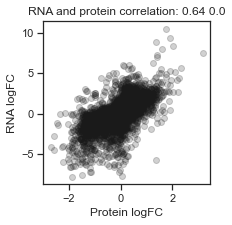

In [36]:
prot_df = pd.read_csv(f'{data_dir}prot_DE_{test_title}_sircle.csv')
rna_df = pd.read_csv(f'{data_dir}rna_DE_{test_title}_sircle.csv')
from scipy.stats import pearsonr

genes = list(set(prot_df['ensembl_gene_id'].values)&set(rna_df['ensembl_gene_id'].values))
v_r = rna_df[rna_df.set_index('ensembl_gene_id').index.isin(genes)].sort_values('ensembl_gene_id')
v_p = prot_df[prot_df.set_index('ensembl_gene_id').index.isin(genes)].sort_values('ensembl_gene_id')
v_p.drop_duplicates(subset='ensembl_gene_id', inplace=True)
v_r.drop_duplicates(subset='ensembl_gene_id', inplace=True)

plt.scatter( v_p['logFC_protein'].values, v_r['logFC_rna'].values, alpha=0.2, c='k')
corr, p_corr = pearsonr( v_p['logFC_protein'].values, v_r['logFC_rna'].values)
plt.title(f'RNA and protein correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('Protein logFC')
plt.ylabel('RNA logFC')
plt.savefig(f'{fig_dir}Fig1A_RNA_Protein_corr.svg')

# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and Protein: ', corr, p_corr])


In [35]:
len(v_r)

10891

(array([3.6000e+01, 4.1300e+02, 1.1950e+03, 1.1261e+04, 1.8775e+04,
        1.9770e+03, 2.5900e+02, 5.5000e+01, 1.4000e+01, 3.0000e+00]),
 array([-8.56992906, -6.47785441, -4.38577976, -2.29370511, -0.20163045,
         1.8904442 ,  3.98251885,  6.0745935 ,  8.16666815, 10.2587428 ,
        12.35081745]),
 <BarContainer object of 10 artists>)

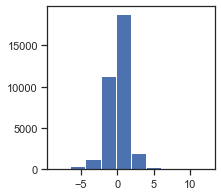

In [25]:
plt.hist(rna_df['logFC_rna'].values, bins=10)

(array([1.100e+01, 9.000e+01, 4.920e+02, 1.464e+03, 6.518e+03, 2.411e+03,
        3.190e+02, 4.200e+01, 7.000e+00, 1.000e+00]),
 array([-2.70812091, -2.11958273, -1.53104456, -0.94250638, -0.3539682 ,
         0.23456997,  0.82310815,  1.41164633,  2.00018451,  2.58872268,
         3.17726086]),
 <BarContainer object of 10 artists>)

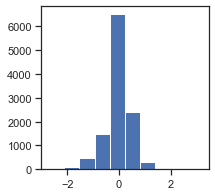

In [26]:
plt.hist(prot_df['logFC_protein'].values, bins=10)

## Test copula correlation

In [27]:
print(np.std(v_p['logFC_protein'].values), np.std(v_r['logFC_rna'].values))

0.4894415774554938 1.2030189680500991


--------------------------------------------------------------------------------
    Pearson correlation between RNAseq and Protein: 	0.6709383907979879	0.0	    
--------------------------------------------------------------------------------


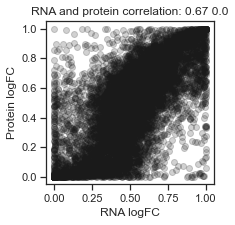

In [28]:
from scipy.stats import norm
rna_cdf = norm.cdf(v_r['logFC_rna'].values, 0, 1.4)
prot_cdf = norm.cdf(v_p['logFC_protein'].values, 0, 0.5)
plt.scatter(rna_cdf, prot_cdf, alpha=0.2, c='k')
corr, p_corr = pearsonr(rna_cdf, prot_cdf)
plt.title(f'RNA and protein correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('RNA logFC')
plt.ylabel('Protein logFC')
u.dp(['Pearson correlation between RNAseq and Protein: ', corr, p_corr])
plt.show()

## Combine RNA and methylation data

In [29]:
genes = list(set(meth_df['external_gene_name'].values)&set(rna_df['external_gene_name'].values))
v_r = rna_df[rna_df.set_index('external_gene_name').index.isin(genes)].sort_values('external_gene_name')
v_p = meth_df[meth_df.set_index('external_gene_name').index.isin(genes)].sort_values('external_gene_name')

rna_meth = v_p.join(v_r, lsuffix='', rsuffix='_')
rna_meth

,Unnamed: 0,Locus,chr,pos,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,Relation_to_Island,UCSC_RefGene_Group,...,RNA_Tumor_C3N.01524_3,RNA_Normal_C3N.01646_1,RNA_Tumor_C3N.01646_1,RNA_Normal_C3N.01648_1,RNA_Normal_C3N.01649_1,RNA_Tumor_C3N.01649_1,RNA_Normal_C3N.01651_1,RNA_Tumor_C3N.01651_1,RNA_Normal_C3N.01808_1,RNA_Tumor_C3N.01808_1
166341,cg24393602,cg24393602,chr6,52995606,ENSG00000202198,7SK,0,0,S_Shore,TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66855,cg08830754,cg08830754,chr6,52995436,ENSG00000202198,7SK,0,0,S_Shore,TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155112,cg22568540,cg22568540,chr19,58353480,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;5'UTR;1stExon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124590,cg17498272,cg17498272,chr19,58353563,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59196,cg07739758,cg07739758,chr19,58354001,ENSG00000121410,A1BG,A1BG,1,N_Shelf,Body;TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134548,cg19105961,cg19105961,chr17,4142929,ENSG00000074755,ZZEF1,ZZEF1,23140,Island,TSS1500;5'UTR;1stExon;TSS1500;TSS1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19873,cg02459389,cg02459389,chr17,4019718,ENSG00000074755,ZZEF1,ZZEF1,23140,OpenSea,Body,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11060,cg01341891,cg01341891,chr1,77682042,ENSG00000036549,ZZZ3,ZZZ3,26009,N_Shore,5'UTR,...,7.532377,6.027899,7.85286,6.769411,5.845572,8.083454,7.000563,8.019076,7.010768,7.782185
167499,cg24577193,cg24577193,chr1,77682711,ENSG00000036549,ZZZ3,ZZZ3,26009,Island,TSS200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
Pearson correlation between RNAseq and DNA methylation: 	-0.0039863098067630925	0.6272710460579092	
--------------------------------------------------------------------------------


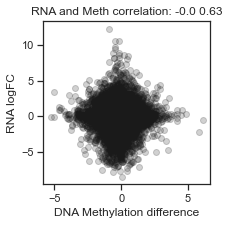

In [30]:

plt.scatter(rna_meth['logFC_meth'].values, rna_meth['logFC_rna'].values, alpha=0.2, c='k')
rna_meth = rna_meth.dropna()

corr, p_corr = pearsonr(rna_meth['logFC_meth'].values, rna_meth['logFC_rna'].values)
plt.title(f'RNA and Meth correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('DNA Methylation difference')
plt.ylabel('RNA logFC')
plt.savefig(f'{fig_dir}Fig1A_RNA_Meth_corr_{meth_test_title}.svg')
# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and DNA methylation: ', corr, p_corr])

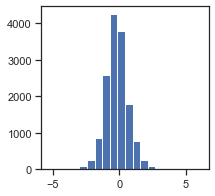

--------------------------------------------------------------------------------
Pearson correlation between RNAseq and DNA methylation Beta: 	-0.172699114287582	3.3929936065564195e-114	
--------------------------------------------------------------------------------


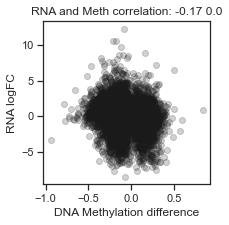

In [31]:
plt.hist(rna_meth['logFC_meth'].values, bins=20)
plt.show()
genes = list(set(meth_f_df['ensembl_gene_id'].values)&set(rna_df['ensembl_gene_id'].values))
rna_df.set_index('ensembl_gene_id', inplace=True)
v_r = rna_df[rna_df.index.isin(genes)].sort_values('ensembl_gene_id')
meth_f_df.set_index('ensembl_gene_id', inplace=True)
v_p = meth_f_df[meth_f_df.index.isin(genes)].sort_values('ensembl_gene_id')
rna_meth = v_p.join(v_r, lsuffix='', rsuffix='_')
rna_meth
plt.scatter(v_p['CpG_Beta_diff'].values, v_r['logFC_rna'].values, alpha=0.2, c='k')
corr, p_corr = pearsonr(v_p['CpG_Beta_diff'].values, v_r['logFC_rna'].values)
plt.title(f'RNA and Meth correlation: {round(corr, 2)} {round(p_corr, 2)}')
plt.xlabel('DNA Methylation difference')
plt.ylabel('RNA logFC')
plt.savefig(f'{fig_dir}Fig1A_RNA_Meth_Beta_corr_{meth_test_title}.svg')
# Print out the pearson correlation
u.dp(['Pearson correlation between RNAseq and DNA methylation Beta: ', corr, p_corr])